In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys, time
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib
from sklearn import manifold
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [3]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2

In [4]:
import pywt

In [5]:
from imp import reload
import glob

In [6]:
# os.chdir('..')
os.chdir('/home/mike/ve/ml/')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics
from eegkaggle.models import neural
from keras.utils import np_utils
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise, GaussianDropout, Activation
from keras.models import Model, Sequential

/home/mike/ve/ml


Using TensorFlow backend.


In [7]:
print(matplotlib.style.available)
matplotlib.style.use('dark_background')
colors = ['k', 'r', 'g', 'b', 'm', 'y', 'c']


[u'seaborn-darkgrid', u'seaborn-notebook', u'seaborn-muted', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'classic', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [8]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

In [9]:
reload(dataio)
guess_path = '/run/media/mike/Elements/data/kaggle/melbourne/test_new/vec_metric_pow_0283_468_0'
x_train, y_train = dataio.reload_with_labels('/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_metric_pow_0275_890_0')
x_guess, y_guess = dataio.reload_with_labels(guess_path)
files2 = pd.read_csv(guess_path + '_name.csv') 
print(x_train.shape, y_train.shape)

(6041, 22) (6041, 1)


In [10]:
d0, d1, dt = dataio.separate_sets(x_train, y_train)

In [11]:
mean0 = np.mean(d0, axis=0)
mean1 = np.mean(d1, axis=0)
std0 = np.std(d0, axis=0)
std1 = np.std(d1, axis=0)

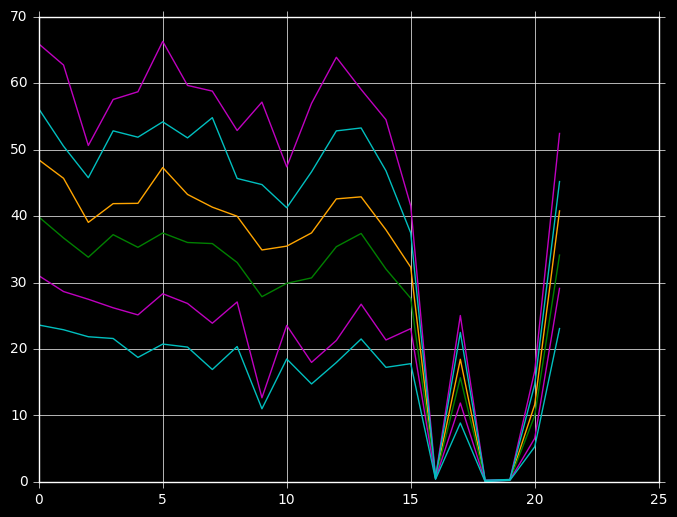

In [12]:
plt.plot(mean0, c='orange')
plt.plot(mean1, c='green')
plt.plot(mean0+std0, 'm')
plt.plot(mean0-std0, 'm')
plt.plot(mean1+std1, 'c')
plt.plot(mean1-std1, 'c')

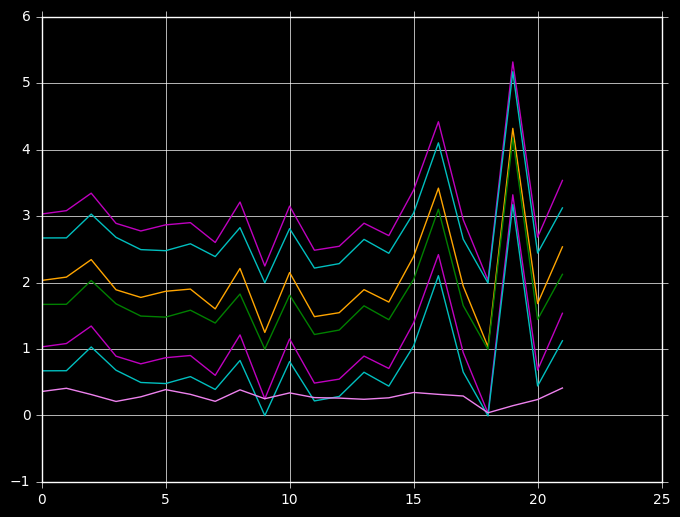

In [17]:
normstd = (std0**2 + std1**2)**0.5
plt.plot(mean0/normstd, c='orange')
plt.plot(mean1/normstd, c='green')
plt.plot(mean0/normstd +1, 'm')
plt.plot(mean0/normstd -1, 'm')
plt.plot(mean1/normstd +1, 'c')
plt.plot(mean1/normstd -1, 'c')
plt.plot((mean0 - mean1)/normstd, 'violet')

In [ ]:
print(np.mean(mean0/))

In [217]:
x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train_z = (x_train - x_mean) / x_std
x_guess_z = (x_guess - x_mean) / x_std
d0_z = (d0 - x_mean) / x_std
d1_z = (d1 - x_mean) / x_std

In [152]:
x_train_s = np.concatenate([d0, d1], axis=0)
x_mean = np.mean(x_train_s, axis=0)
x_std = np.std(x_train_s, axis=0)
x_train_s = (x_train_s - x_mean) / x_std

In [153]:
tsne = manifold.TSNE(random_state=1337)
txdata = tsne.fit_transform(x_train_s)

In [154]:
def scatter_heat(sorted_data, class_cut, rad=200, alpha=0.2):
    plt.scatter(txdata[:class_cut, 0], txdata[:class_cut, 1], edgecolor='none', c='b', s=3)
    plt.scatter(txdata[class_cut:, 0], txdata[class_cut:, 1], edgecolor='none', c='orange', s=rad, alpha=alpha )
    plt.scatter(txdata[class_cut:, 0], txdata[class_cut:, 1], edgecolor='none', c='r', s=5 )

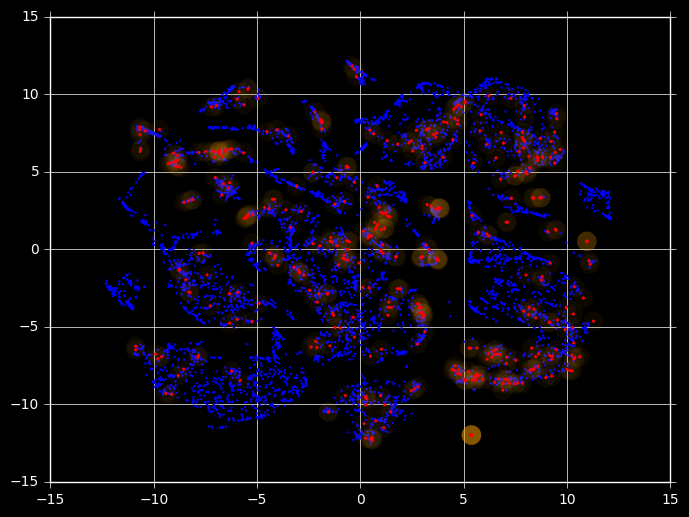

In [155]:
scatter_heat(txdata, len(d0), alpha=0.05)

In [210]:
reload(neural)
batch_size = 100
autoclasser = neural.SimpleAutoClasser(x_train.shape, batch_size=batch_size, latent_dim=2)
ae, enc, dec, classer = autoclasser.get_models()

DS shape: (6041, 22)
Input Dims: 22, input shape: (22,), encoding dims: 2
('Batch Shape: ', (100, 22))


In [211]:
(x_train2, y_train2), (x_val2, y_val2) = dataio.subdiv_split_shuffle(x_train_z, y_train, validation_split=0.505)
x_train2.reshape(x_train2.shape[0], x_train2.shape[1], 1)
# y_train2 = np_utils.to_categorical(np.asarray(y_train2, dtype=int), nb_classes=2)
y_val2 = np_utils.to_categorical(np.asarray(y_val2, dtype=int), nb_classes=2)
print(x_train2.shape, y_train2.shape, x_val2.shape, y_val2.shape)

val_cut:  226
(5589, 22) (5589, 1) (452, 22) (452, 2)


In [212]:
ae.fit(x_train2, x_train2, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, x_val2))

Train on 5589 samples, validate on 452 samples
Epoch 1/3
5589/5589 [==============================] - 1s - loss: -0.6987 - val_loss: -2.9809
Epoch 2/3
5589/5589 [==============================] - 0s - loss: -1.1429 - val_loss: -3.3372
Epoch 3/3
5589/5589 [==============================] - 0s - loss: -1.4390 - val_loss: -3.8496


In [112]:
# classer.fit(x_train2, y_train2, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

In [213]:
# Train just the classer
nb_mega = 3
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, y_val2))

Mega-epoch 0 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.6952 - acc: 0.6570 - val_loss: 0.6611 - val_acc: 0.6106
Mega-epoch 1 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.7072 - acc: 0.6031 - val_loss: 0.6598 - val_acc: 0.6173
Mega-epoch 2 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.6879 - acc: 0.6614 - val_loss: 0.6592 - val_acc: 0.6195


In [207]:
# CROSSTRAIN
nb_mega = 3
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, y_val2))

Mega-epoch 0 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.6637 - acc: 0.6726 - val_loss: 0.6574 - val_acc: 0.6106
Mega-epoch 1 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.6806 - acc: 0.6233 - val_loss: 0.6567 - val_acc: 0.6106
Mega-epoch 2 of 3
Train on 446 samples, validate on 452 samples
Epoch 1/1
446/446 [==============================] - 0s - loss: 0.6675 - acc: 0.6592 - val_loss: 0.6566 - val_acc: 0.6173


In [218]:
encoded0 = autoclasser.encoder.predict(d0_z)
encoded1 = autoclasser.encoder.predict(d1_z)

In [215]:
encoded.shape

(6041, 2)

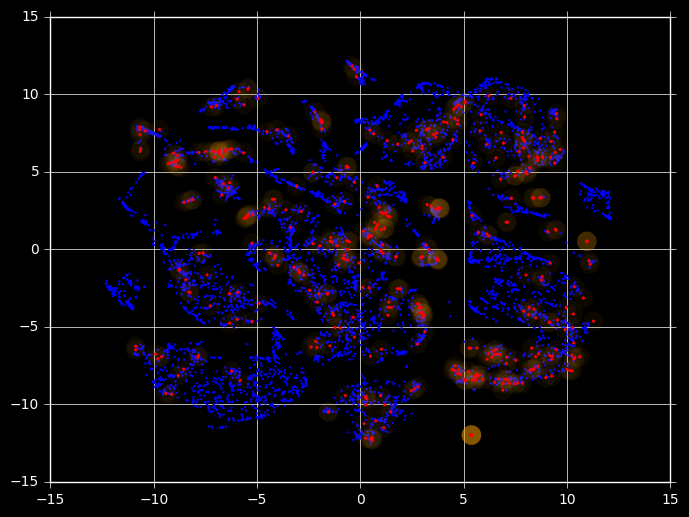

In [222]:
# plt.scatter(encoded0[:,0], encoded0[:,1])
# plt.scatter(encoded1[:,0], encoded1[:,1])
scatter_heat(np.concatenate([d0_z, d1_z], axis=0), len(d0_z), alpha=.05)

In [172]:
nb_hidden = 255 # number of hidden nodes
nb_classes = 2 # ten digits, so ten output nodes (one-hot)
nb_epoch = 3 # number of epochs. 1 epoch is training once on the entire set of training samples

input_dim = x_train.shape[1] # 28x28 = 784
model = Sequential()
model.add(Dense(nb_hidden, activation='linear', input_dim=input_dim))
model.add(GaussianNoise(0.2))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(Dense(output_dim=nb_classes, activation='sigmoid')) # Here we use sigmoid because we wanna force the output to 0-1

In [173]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
nb_mega = 20
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    model.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

Mega-epoch 0 of 20
Train on 446 samples, validate on 452 samples
Epoch 1/3
446/446 [==============================] - 1s - loss: 0.8290 - acc: 0.5336 - val_loss: 0.6637 - val_acc: 0.6117
Epoch 2/3
446/446 [==============================] - 0s - loss: 0.7182 - acc: 0.6244 - val_loss: 0.6604 - val_acc: 0.6051
Epoch 3/3
446/446 [==============================] - 0s - loss: 0.6682 - acc: 0.6446 - val_loss: 0.6601 - val_acc: 0.6007
Mega-epoch 1 of 20
Train on 446 samples, validate on 452 samples
Epoch 1/3
446/446 [==============================] - 0s - loss: 0.7498 - acc: 0.6188 - val_loss: 0.6650 - val_acc: 0.5896
Epoch 2/3
446/446 [==============================] - 0s - loss: 0.6981 - acc: 0.6278 - val_loss: 0.6588 - val_acc: 0.6184
Epoch 3/3
446/446 [==============================] - 0s - loss: 0.6882 - acc: 0.6110 - val_loss: 0.6575 - val_acc: 0.6350
Mega-epoch 2 of 20
Train on 446 samples, validate on 452 samples
Epoch 1/3
446/446 [==============================] - 0s - loss: 0.6686 - 

In [176]:
pred_classes = model.predict_classes(x_val2) # Let the model automatically determine the classes

448/452 [============================>.] - ETA: 0s

In [177]:
pred_classes

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1,

In [179]:
valacc = np.mean(pred_classes == y_val2[:,1]) # Final accuracy on validation batch
print('Validation Accuracy: {}'.format(valacc))

Validation Accuracy: 0.652654867257


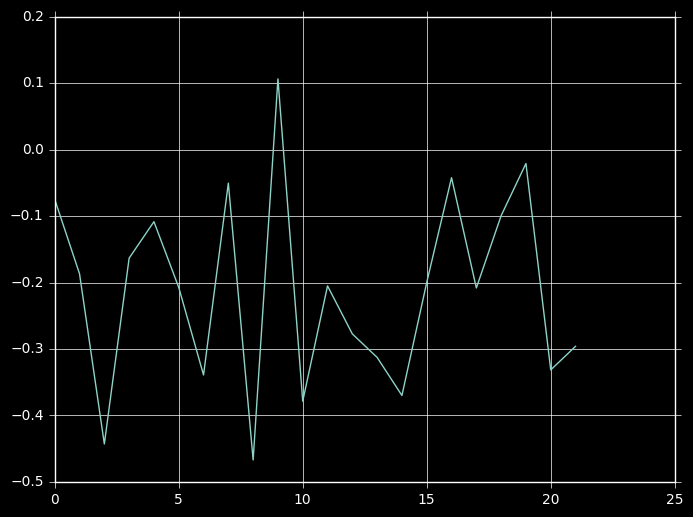

In [185]:
plt.plot(np.mean(x_guess_z, axis=0))

In [186]:
guess = model.predict_classes(x_guess_z)

1888/1908 [============================>.] - ETA: 0s

In [187]:
np.mean(guess, axis=0)

0.42295597484276731

In [191]:
files2['Class'] = pd.Series(guess, dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [194]:
time_start = int(time.time())
time_str = str(time_start)[-7:-3] + '_' + str(time_start)[-3:]
files2.to_csv('./eegkaggle/guesses/new_cnn_11_27_{}.csv'.format(time_str)) # fix this 